<a href="https://colab.research.google.com/github/Reaper-ai/brain-tumor-CSRE/blob/main/notebooks/btcs_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Download dataset**

In [1]:
# Upload your Kaggle API token first
from google.colab import files
files.upload()  # upload kaggle.json

# Move to kaggle folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle CLI and download dataset
!pip install -q kaggle
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip -d data/


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 60% 89.0M/149M [00:00<00:00, 930MB/s]
100% 149M/149M [00:00<00:00, 715MB/s] 


**Imports**

In [2]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import zipfile

**Extract data**

In [3]:
zip_path = "/content/brain-tumor-mri-dataset.zip"
extract_path = "/data/brain_tumor_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)

Dataset extracted to: /data/brain_tumor_dataset


**Data loaders**

In [6]:
train_dir = 'data/Training'
test_dir = 'data/Testing'
img_size = 224
batch_size = 32

# Define transforms
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Train-validation split
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


**Load model :  mobilenet**

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 4)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 195MB/s]


**Training**

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct = 0

    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = 0
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_acc += (outputs.argmax(1) == labels).sum().item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.2f}, Train Acc: {correct/len(train_loader.dataset):.4f}, Val Acc: {val_acc/len(val_loader.dataset):.4f}")


100%|██████████| 179/179 [00:51<00:00,  3.50it/s]


Epoch 1/10, Loss: 47.93, Train Acc: 0.9084, Val Acc: 0.9596


100%|██████████| 179/179 [00:47<00:00,  3.80it/s]


Epoch 2/10, Loss: 11.60, Train Acc: 0.9806, Val Acc: 0.9855


100%|██████████| 179/179 [00:47<00:00,  3.80it/s]


Epoch 3/10, Loss: 5.53, Train Acc: 0.9914, Val Acc: 0.9786


100%|██████████| 179/179 [00:47<00:00,  3.80it/s]


Epoch 4/10, Loss: 4.93, Train Acc: 0.9921, Val Acc: 0.9855


100%|██████████| 179/179 [00:46<00:00,  3.83it/s]


Epoch 5/10, Loss: 2.17, Train Acc: 0.9968, Val Acc: 0.9855


100%|██████████| 179/179 [00:46<00:00,  3.82it/s]


Epoch 6/10, Loss: 2.39, Train Acc: 0.9958, Val Acc: 0.9863


100%|██████████| 179/179 [00:47<00:00,  3.80it/s]


Epoch 7/10, Loss: 3.38, Train Acc: 0.9953, Val Acc: 0.9809


100%|██████████| 179/179 [00:46<00:00,  3.84it/s]


Epoch 8/10, Loss: 3.42, Train Acc: 0.9939, Val Acc: 0.9886


100%|██████████| 179/179 [00:46<00:00,  3.81it/s]


Epoch 9/10, Loss: 1.44, Train Acc: 0.9979, Val Acc: 0.9908


100%|██████████| 179/179 [00:46<00:00,  3.82it/s]


Epoch 10/10, Loss: 0.85, Train Acc: 0.9993, Val Acc: 0.9901


**Save weights**

In [8]:
torch.save(model.state_dict(), "brain_tumor_classifier.pth")

**Evaluation**



              precision    recall  f1-score   support

      glioma       1.00      0.97      0.99       300
  meningioma       0.97      0.99      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



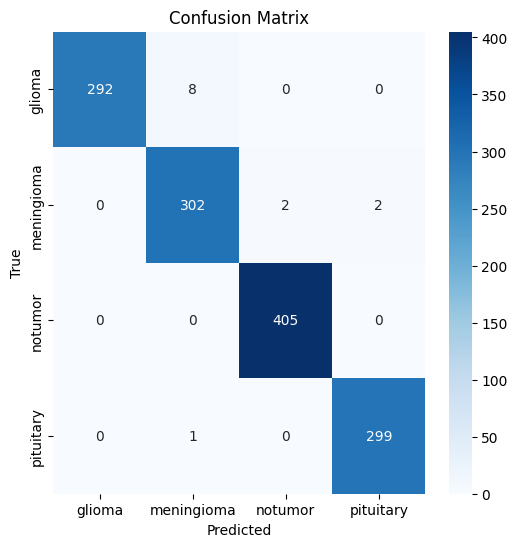

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()